---
# Validation of RNN model
---

In this notebook, we will validate our RNN model by producing the Mean Squared Error by using the RNN model to predict the daily maximum/minimum temperatures and comparing the results with the observed temperatures.

</br>

---
### Results :

| ** MSE Metric** | **Value**        |
|------------|------------------|
| **Tmax** | 4.500 |
| **Tmin** | 4.160 |

</br>

![](../images/validation_results.png)


---
### Further work
We are hoping to adress those issues shortly:

  - Improving the sin curve passed to the model for training (fixing weird peak)


### Loading necessary libraries

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import joblib

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Define files

In [5]:
#data_dir = '../data/'
data_dir = 'C:\\Users\\jocl0\\ABF\\Final_Project-main\\data\\'

model_dir = 'C:\\Users\\jocl0\\ABF\\Final_Project-main\\model\\'
#model_dir = '../model/'

#ghg = 'GreenHouse_Gases/processed/'
ghg = 'GreenHouse_Gases\\processed\\'

frequency = 'DLY'

climate_file = 'ECCC\\processed\\daily\\daily_processed.csv'
#climate_file = 'ECCC/processed/daily/daily_processed.csv'
#climate_file = 'ECCC/processed/monthly/monthly_processed.csv'

population_file = 'Population\\processed\\Montreal.csv'
#population_file = 'Population/processed/Montreal.csv'

co2_file = 'co2_1850-2099_SSP2_45.csv'
ch4_file = 'ch4_1850-2099_SSP2_45.csv'

scenario = 'SSP2-45'

### Define variables

**Daily**

In [8]:
Tmax = 'Max Temp (°C)'
Tmin =  'Min Temp (°C)' 

### Read data files

In [10]:
co2_df = pd.read_csv(os.path.join(data_dir, ghg, co2_file), index_col=0, parse_dates=True)
co2_df.drop(columns = 'Data Source', inplace=True)
co2_df

,CO2
Year,
1850-01-01,285.200000
1851-01-01,285.100000
1852-01-01,285.000000
1853-01-01,285.000000
1854-01-01,284.900000
...,...
2095-01-01,600.885986
2096-01-01,601.365967
2097-01-01,601.796997


In [11]:
ch4_df = pd.read_csv(os.path.join(data_dir, ghg, ch4_file), index_col=0, parse_dates=True)
ch4_df

,CH4
Year,
1850-01-01,791.600000
1851-01-01,792.859068
1852-01-01,794.156502
1853-01-01,795.493289
1854-01-01,796.859405
...,...
2095-01-01,1698.879883
2096-01-01,1695.429810
2097-01-01,1692.139893


In [12]:
pop_df = pd.read_csv(os.path.join(data_dir, population_file), index_col=0, parse_dates=True)
pop_df

,Population
1801-01-01,9.000000e+03
1802-01-01,9.389547e+03
1803-01-01,9.788026e+03
1804-01-01,1.019544e+04
1805-01-01,1.061293e+04
...,...
2095-01-01,2.258385e+06
2096-01-01,2.249969e+06
2097-01-01,2.240726e+06
2098-01-01,2.230707e+06


In [13]:
wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)
wx_df

C:\Users\jocl0\AppData\Local\Temp\ipykernel_29932\1851272773.py:1: DtypeWarning: Columns (5,11,13,15,17,19,27,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)


,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
Date/Time,,,,,,,,,,,,,,,,,,,,,
1891-10-22,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,22,NaN,5.6,...,0.0,T,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-23,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,23,NaN,3.9,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-24,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,24,NaN,5.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-25,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,25,NaN,3.3,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-26,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,26,NaN,10.6,...,0.0,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,23,NaN,-1.6,...,NaN,NaN,0.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN
2025-03-24,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,24,NaN,3.9,...,NaN,NaN,6.7,NaN,9.0,NaN,NaN,NaN,NaN,NaN
2025-03-25,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,25,NaN,4.5,...,NaN,NaN,1.1,NaN,11.0,NaN,NaN,NaN,NaN,NaN


### Adding columns of lagged temperature features (yesterday's min/max temperature)

In [15]:
wx_df['tmin_lag1'] = wx_df[Tmin].shift(1)
wx_df['tmax_lag1'] = wx_df[Tmax].shift(1)
wx_df

,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,tmin_lag1,tmax_lag1
Date/Time,,,,,,,,,,,,,,,,,,,,,
1891-10-22,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,22,NaN,5.6,...,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-23,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,23,NaN,3.9,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,5.6
1891-10-24,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,24,NaN,5.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.1,3.9
1891-10-25,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,25,NaN,3.3,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.2,5.0
1891-10-26,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,26,NaN,10.6,...,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.3,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,23,NaN,-1.6,...,0.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,-7.5,10.7
2025-03-24,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,24,NaN,3.9,...,6.7,NaN,9.0,NaN,NaN,NaN,NaN,NaN,-9.8,-1.6
2025-03-25,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,25,NaN,4.5,...,1.1,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-4.6,3.9


### Remove incomplete start and end year of climate dataset

In [17]:
tmp = wx_df.groupby(['Year']).count()

tmp[tmp['Station'] < 365]

,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,tmin_lag1,tmax_lag1
Year,,,,,,,,,,,,,,,,,,,,,
1891,71,71,71,71,71,71,71,0,71,0,...,71,10,0,0,0,0,0,0,70,70
2025,86,86,86,86,86,86,86,0,86,0,...,85,1,86,0,27,0,27,0,86,86


In [18]:
start_wx = wx_df.index.min()
end_wx = wx_df.index.max()
print(type(start_wx), end_wx)

for year in [start_wx, end_wx] :

    nbr_days_year = 366 if pd.Period(year, freq='Y').is_leap_year else 365

    yr = int(year.strftime('%Y'))
    nbr_obs_year = tmp[tmp.index == yr]['Station'].values[0]

    print('*',yr, nbr_obs_year, '*')
    
    if nbr_obs_year != nbr_days_year :
        print(f'Not full year. Removing partial {yr} from dataframe')
        wx_df = wx_df[wx_df['Year'] != yr]

        start_wx = wx_df.index.min()
        end_wx = wx_df.index.max()
    else :
        print(f'Full year. Not removing {yr} from obs dataframe.')
    
wx_df

<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2025-03-27 00:00:00
* 1891 71 *
Not full year. Removing partial 1891 from dataframe
* 2025 86 *
Not full year. Removing partial 2025 from dataframe


,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,tmin_lag1,tmax_lag1
Date/Time,,,,,,,,,,,,,,,,,,,,,
1892-01-01,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,1,NaN,-5.6,...,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN,-18.3,-10.6
1892-01-02,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,2,NaN,6.7,...,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.7,-5.6
1892-01-03,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,3,NaN,2.2,...,11.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.1,6.7
1892-01-04,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,4,NaN,-7.2,...,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.8,2.2
1892-01-05,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,5,NaN,-12.2,...,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-15.0,-7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,27,NaN,-6.1,...,0.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-13.7,-7.9
2024-12-28,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,28,NaN,-1.7,...,0.2,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-13.2,-6.1
2024-12-29,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,29,NaN,7.6,...,5.2,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-9.6,-1.7


### Put the GreenHouse Gases dataframe and population dataframe on the same frequency as the climate data

In [20]:
if frequency == 'DLY':
    new_range = pd.date_range(start = start_wx, end = end_wx, freq="D")
    print(new_range)
    
    co2_df = co2_df.reindex(new_range)
    co2_df = co2_df.resample('D').interpolate()

    ch4_df = ch4_df.reindex(new_range)
    ch4_df = ch4_df.resample('D').interpolate()

    pop_df = pop_df.reindex(new_range)
    pop_df = pop_df.resample('D').interpolate()
    
elif frequency == 'MLY':
    new_range = pd.date_range(start = start_wx, end = end_wx, freq="ME")
    print(new_range)

    co2_df = co2_df.reindex(new_range)
    co2_df = co2_df.resample('ME').interpolate()

    ch4_df = ch4_df.reindex(new_range)
    ch4_df = ch4_df.resample('ME').interpolate()

    pop_df = pop_df.reindex(new_range)
    pop_df = pop_df.resample('ME').interpolate()
else :
    print('Frequency is NOT monthly or daily')

DatetimeIndex(['1892-01-01', '1892-01-02', '1892-01-03', '1892-01-04',
               '1892-01-05', '1892-01-06', '1892-01-07', '1892-01-08',
               '1892-01-09', '1892-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=48578, freq='D')


In [21]:
co2_df

,CO2
1892-01-01,294.800000
1892-01-02,294.799727
1892-01-03,294.799454
1892-01-04,294.799180
1892-01-05,294.798907
...,...
2024-12-27,424.610000
2024-12-28,424.610000
2024-12-29,424.610000
2024-12-30,424.610000


In [22]:
ch4_df

,CH4
1892-01-01,859.921329
1892-01-02,859.925885
1892-01-03,859.930442
1892-01-04,859.934998
1892-01-05,859.939554
...,...
2024-12-27,1934.802141
2024-12-28,1934.802141
2024-12-29,1934.802141
2024-12-30,1934.802141


In [23]:
pop_df

,Population
1892-01-01,2.609199e+05
1892-01-02,2.609370e+05
1892-01-03,2.609540e+05
1892-01-04,2.609711e+05
1892-01-05,2.609881e+05
...,...
2024-12-27,2.200807e+06
2024-12-28,2.200807e+06
2024-12-29,2.200807e+06
2024-12-30,2.200807e+06


### Put all the data into a single dataframe

In [25]:
full_df = pd.concat([co2_df, ch4_df, pop_df, wx_df[[Tmax,Tmin]]], axis=1)
full_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C)
1892-01-01,294.800000,859.921329,2.609199e+05,-5.6,-11.7
1892-01-02,294.799727,859.925885,2.609370e+05,6.7,-6.1
1892-01-03,294.799454,859.930442,2.609540e+05,2.2,-7.8
1892-01-04,294.799180,859.934998,2.609711e+05,-7.2,-15.0
1892-01-05,294.798907,859.939554,2.609881e+05,-12.2,-16.7
...,...,...,...,...,...
2024-12-27,424.610000,1934.802141,2.200807e+06,-6.1,-13.2
2024-12-28,424.610000,1934.802141,2.200807e+06,-1.7,-9.6
2024-12-29,424.610000,1934.802141,2.200807e+06,7.6,-2.6
2024-12-30,424.610000,1934.802141,2.200807e+06,10.6,3.3


### Add lagged temperature features

In [27]:
full_df['tmin_lag1'] = wx_df['tmin_lag1']
full_df['tmax_lag1'] = wx_df['tmax_lag1']
full_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1
1892-01-01,294.800000,859.921329,2.609199e+05,-5.6,-11.7,-18.3,-10.6
1892-01-02,294.799727,859.925885,2.609370e+05,6.7,-6.1,-11.7,-5.6
1892-01-03,294.799454,859.930442,2.609540e+05,2.2,-7.8,-6.1,6.7
1892-01-04,294.799180,859.934998,2.609711e+05,-7.2,-15.0,-7.8,2.2
1892-01-05,294.798907,859.939554,2.609881e+05,-12.2,-16.7,-15.0,-7.2
...,...,...,...,...,...,...,...
2024-12-27,424.610000,1934.802141,2.200807e+06,-6.1,-13.2,-13.7,-7.9
2024-12-28,424.610000,1934.802141,2.200807e+06,-1.7,-9.6,-13.2,-6.1
2024-12-29,424.610000,1934.802141,2.200807e+06,7.6,-2.6,-9.6,-1.7
2024-12-30,424.610000,1934.802141,2.200807e+06,10.6,3.3,-2.6,7.6


In [28]:
full_df['dayofyear'] = full_df.index.dayofyear
full_df['sin'] = 80 * np.sin((np.pi/(365+31)) * full_df['dayofyear']) -30
full_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear,sin
1892-01-01,294.800000,859.921329,2.609199e+05,-5.6,-11.7,-18.3,-10.6,1,-29.365341
1892-01-02,294.799727,859.925885,2.609370e+05,6.7,-6.1,-11.7,-5.6,2,-28.730723
1892-01-03,294.799454,859.930442,2.609540e+05,2.2,-7.8,-6.1,6.7,3,-28.096184
1892-01-04,294.799180,859.934998,2.609711e+05,-7.2,-15.0,-7.8,2.2,4,-27.461765
1892-01-05,294.798907,859.939554,2.609881e+05,-12.2,-16.7,-15.0,-7.2,5,-26.827506
...,...,...,...,...,...,...,...,...,...
2024-12-27,424.610000,1934.802141,2.200807e+06,-6.1,-13.2,-13.7,-7.9,362,-8.682095
2024-12-28,424.610000,1934.802141,2.200807e+06,-1.7,-9.6,-13.2,-6.1,363,-9.294476
2024-12-29,424.610000,1934.802141,2.200807e+06,7.6,-2.6,-9.6,-1.7,364,-9.908161
2024-12-30,424.610000,1934.802141,2.200807e+06,10.6,3.3,-2.6,7.6,365,-10.523110


### Separate Train/Test/Validate dataset

In [30]:
cut_year_test = 2021
cut_year_val = 2023

cut_test = pd.to_datetime(cut_year_test, format='%Y')
cut_val = pd.to_datetime(cut_year_val, format='%Y')

test_df = full_df[(full_df.index >= cut_test) & (full_df.index < cut_val)]
val_df = full_df[full_df.index >= cut_val]

In [31]:
test_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear,sin
2021-01-01,416.410000,1894.800000,1.762949e+06,-0.2,-5.1,-6.9,3.7,1,-29.365341
2021-01-02,416.415808,1894.844164,1.763361e+06,-0.6,-5.3,-5.1,-0.2,2,-28.730723
2021-01-03,416.421616,1894.888329,1.763773e+06,-0.6,-3.5,-5.3,-0.6,3,-28.096184
2021-01-04,416.427425,1894.932493,1.764185e+06,-1.1,-3.4,-3.5,-0.6,4,-27.461765
2021-01-05,416.433233,1894.976658,1.764598e+06,-2.5,-3.6,-3.4,-1.1,5,-26.827506
...,...,...,...,...,...,...,...,...,...
2022-12-27,421.045068,1921.552329,2.100692e+06,-4.2,-8.7,-8.9,-3.3,361,-8.071055
2022-12-28,421.052055,1921.581863,2.101212e+06,0.2,-4.2,-8.7,-4.2,362,-8.682095
2022-12-29,421.059041,1921.611397,2.101732e+06,6.4,-0.6,-4.2,0.2,363,-9.294476
2022-12-30,421.066027,1921.640932,2.102253e+06,9.8,5.1,-0.6,6.4,364,-9.908161


In [32]:
val_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear,sin
2023-01-01,421.080000,1921.700000,2.103293e+06,5.6,0.9,4.2,9.1,1,-29.365341
2023-01-02,421.089671,1921.735896,2.103560e+06,3.9,0.7,0.9,5.6,2,-28.730723
2023-01-03,421.099342,1921.771793,2.103828e+06,4.4,1.6,0.7,3.9,3,-28.096184
2023-01-04,421.109014,1921.807689,2.104095e+06,2.7,-4.2,1.6,4.4,4,-27.461765
2023-01-05,421.118685,1921.843585,2.104362e+06,-2.7,-5.2,-4.2,2.7,5,-26.827506
...,...,...,...,...,...,...,...,...,...
2024-12-27,424.610000,1934.802141,2.200807e+06,-6.1,-13.2,-13.7,-7.9,362,-8.682095
2024-12-28,424.610000,1934.802141,2.200807e+06,-1.7,-9.6,-13.2,-6.1,363,-9.294476
2024-12-29,424.610000,1934.802141,2.200807e+06,7.6,-2.6,-9.6,-1.7,364,-9.908161
2024-12-30,424.610000,1934.802141,2.200807e+06,10.6,3.3,-2.6,7.6,365,-10.523110


### Separate RNN input and output data

In [34]:
cols_in = ['CH4', 'CO2', 'Population', 'tmin_lag1', 'tmax_lag1', 'sin'] #, 'sin_doy', 'cos_doy'] #'dayofyear']
cols_out = [Tmax, Tmin]

X_test = test_df[cols_in]
X_val = val_df[cols_in]

Y_test = test_df[cols_out]
Y_val = val_df[cols_out]

### Scale the dataset

In [36]:
scaler_x = joblib.load(os.path.join(model_dir,'scaler_x.joblib'))
scaler_y = joblib.load(os.path.join(model_dir,'scaler_y.joblib'))

In [37]:
X_scaled_test = scaler_x.transform(X_test)
X_scaled_val = scaler_x.transform(X_val)

Y_scaled_test = scaler_y.transform(Y_val)
Y_scaled_val = scaler_y.transform(Y_val)

### Load RNN model

In [39]:
rnn = load_model(os.path.join(model_dir, 'rnn_months_sin_1month_1024k_more.keras'))

In [40]:
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1024)              4222976   
                                                                 
 dense_2 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 4,225,026
Trainable params: 4,225,026
Non-trainable params: 0
_________________________________________________________________


### Evaluate the model on the validation dataset

In [42]:
rnn_prediction_val = []
window_size = 31 #*3

n_steps = 365 * 2

n_features = X_scaled_test.shape[1]

current_data = X_scaled_test[-(window_size):] 
current_data = current_data.reshape(1, window_size, n_features)

for i in range(n_steps): 
    
    # Prediction for 1 timestep into the future
    current_prediction = rnn.predict(current_data)[0]
    
    # Append it to our list of prediction
    rnn_prediction_val.append(current_prediction)

    next_input_step = X_scaled_val[i].copy()  # shape: (n_features,)
    
    next_input_step[3] = current_prediction[1]
    next_input_step[4] = current_prediction[0]
    next_input_step = next_input_step.reshape(1, 1, n_features)
    
    # next_input_step = X_scaled_val[i].copy()  
    # next_input_step[-2:] = current_prediction  
    # next_input_step = next_input_step.reshape(1, 1, n_features)
    
    current_data = np.append(current_data[:,1:,:], next_input_step, axis=1)

rnn_prediction_val

1/1 [==============================] - 0s 61ms/step


[array([0.46993554, 0.5043698 ], dtype=float32),
 array([0.406594  , 0.41459808], dtype=float32),
 array([0.41258872, 0.4279034 ], dtype=float32),
 array([0.4058504 , 0.42014396], dtype=float32),
 array([0.4046691 , 0.41936073], dtype=float32),
 array([0.40099284, 0.414369  ], dtype=float32),
 array([0.3980775 , 0.41017652], dtype=float32),
 array([0.39432406, 0.40491903], dtype=float32),
 array([0.3904866 , 0.39945918], dtype=float32),
 array([0.3869623 , 0.39442652], dtype=float32),
 array([0.3840183, 0.3901286], dtype=float32),
 array([0.38160014, 0.38652378], dtype=float32),
 array([0.3796071 , 0.38348243], dtype=float32),
 array([0.37811437, 0.3810745 ], dtype=float32),
 array([0.3769852 , 0.37917602], dtype=float32),
 array([0.37624645, 0.37779558], dtype=float32),
 array([0.37566775, 0.3766908 ], dtype=float32),
 array([0.37531048, 0.37587073], dtype=float32),
 array([0.37497714, 0.37496924], dtype=float32),
 array([0.3746422 , 0.37406215], dtype=float32),
 array([0.37438372, 0.

### Inversing prediction

In [44]:
inversed_preds_val = scaler_y.inverse_transform(rnn_prediction_val)

cols_out_new = (pd.Series(cols_out) + 'model').tolist()

pred_val_df = pd.DataFrame(inversed_preds_val, columns=cols_out_new)

pred_val_df.index = val_df.iloc[:n_steps].index

full_pred_val_df = pd.concat([val_df.iloc[:n_steps], pred_val_df], axis=1)

full_pred_val_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear,sin,Max Temp (°C)model,Min Temp (°C)model
2023-01-01,421.080000,1921.700000,2.103293e+06,5.6,0.9,4.2,9.1,1,-29.365341,1.880778,-3.889997
2023-01-02,421.089671,1921.735896,2.103560e+06,3.9,0.7,0.9,5.6,2,-28.730723,-2.268092,-9.231414
2023-01-03,421.099342,1921.771793,2.103828e+06,4.4,1.6,0.7,3.9,3,-28.096184,-1.875439,-8.439747
2023-01-04,421.109014,1921.807689,2.104095e+06,2.7,-4.2,1.6,4.4,4,-27.461765,-2.316798,-8.901434
2023-01-05,421.118685,1921.843585,2.104362e+06,-2.7,-5.2,-4.2,2.7,5,-26.827506,-2.394174,-8.948037
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-26,424.610000,1934.802141,2.200807e+06,-7.9,-13.7,-12.4,-6.3,361,-8.071055,-1.431691,-8.050292
2024-12-27,424.610000,1934.802141,2.200807e+06,-6.1,-13.2,-13.7,-7.9,362,-8.682095,-1.553003,-8.179345
2024-12-28,424.610000,1934.802141,2.200807e+06,-1.7,-9.6,-13.2,-6.1,363,-9.294476,-1.671487,-8.305968
2024-12-29,424.610000,1934.802141,2.200807e+06,7.6,-2.6,-9.6,-1.7,364,-9.908161,-1.787936,-8.430964


### Evaluating model's prediction accuracy
typo here should wrote MSE instaed of RMSE in the print

In [46]:
print(f"Val Tmax RMSE: {np.sqrt(mean_squared_error(full_pred_val_df[Tmax],full_pred_val_df[cols_out_new[0]]))}")
print(f"Val Tmin RMSE: {np.sqrt(mean_squared_error(full_pred_val_df[Tmin],full_pred_val_df[cols_out_new[1]]))}")

Val Tmax RMSE: 4.640995006397309
Val Tmin RMSE: 4.289642397518628


<Axes: >

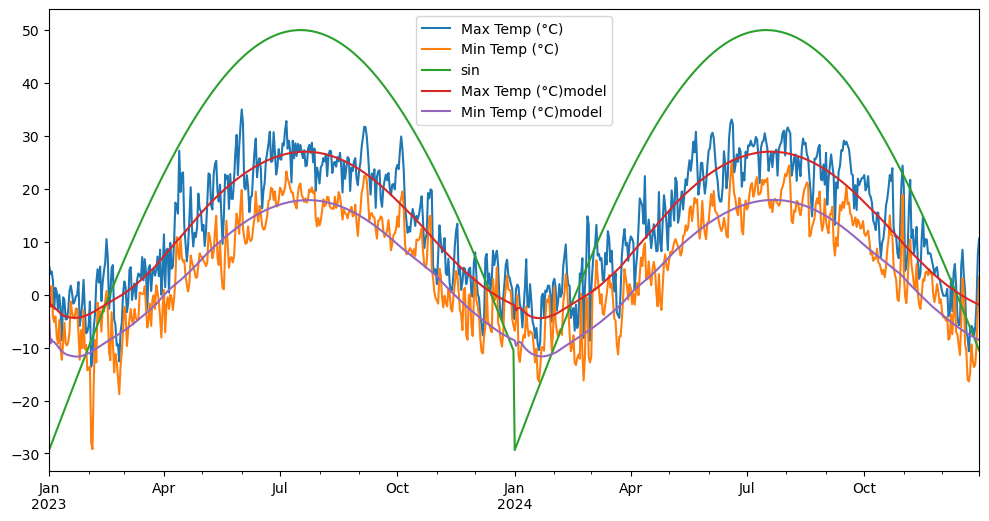

In [79]:
tmp = full_pred_val_df.drop(columns=['CO2', 'CH4', 'Population', 'tmin_lag1',	'tmax_lag1', 'dayofyear'])
tmp.plot(figsize=(12,6))

<Axes: >

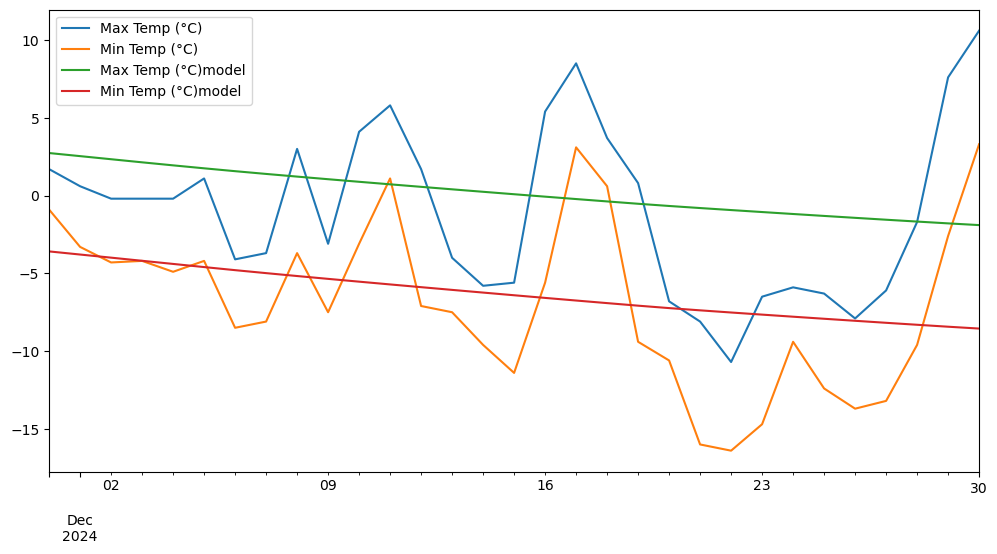

In [48]:
full_pred_val_df.drop(columns=['CO2', 'CH4', 'Population', 'tmin_lag1',	'tmax_lag1', 'dayofyear', 'sin']).iloc[-31:].plot(figsize=(12,6))